In [1]:
#%pip install selenium webdriver-manager


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from io import StringIO


# Set up Chrome WebDriver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# Load the page
url = "https://investors.att.com/stock-information/historical-stock-information/historical-common-dividends/att-inc"
driver.get(url)

# Get page source and parse
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

# Find the dividend table
tables = soup.find_all("table")

dividend_table = pd.read_html(StringIO(str(tables[0])))[0]  # Adjust index if needed
# Display the DataFrame
print(dividend_table)


       Year Payment Date Record Date   Amount
0    2025.0     11-03-25    10-10-25  $0.2775
1    2025.0     05-01-25    04-10-25  $0.2775
2    2025.0     02-03-25    01-10-25  $0.2775
3    2024.0     11-01-24    10-10-24  $0.2775
4    2024.0     08-01-24    07-10-24  $0.2775
..      ...          ...         ...      ...
165  1985.0     05-01-85    04-10-85    $1.50
166  1985.0     02-01-85    01-10-85    $1.40
167  1984.0     11-01-84    09-28-84    $1.40
168  1984.0     08-01-84    06-29-84    $1.40
169  1984.0     05-01-84    03-30-84    $1.40

[170 rows x 4 columns]


In [3]:
# Correct the data type for dividend_table columns
# Drop rows where 'Year' is missing or not a number
dividend_table = dividend_table[pd.to_numeric(dividend_table['Year'], errors='coerce').notnull()]
dividend_table['Year'] = dividend_table['Year'].astype(int)
dividend_table['Payment Date'] = pd.to_datetime(dividend_table['Payment Date'], format='%m-%d-%y', errors='coerce')
dividend_table['Record Date'] = pd.to_datetime(dividend_table['Record Date'], format='%m-%d-%y', errors='coerce')
# Remove $ from 'Amount' and convert to float
dividend_table['Amount'] = dividend_table['Amount'].replace('\$', '', regex=True).astype(float)
print(dividend_table.dtypes)

Year                     int32
Payment Date    datetime64[ns]
Record Date     datetime64[ns]
Amount                 float64
dtype: object


In [4]:
dividend_table

,Year,Payment Date,Record Date,Amount
0,2025,2025-11-03,2025-10-10,0.2775
1,2025,2025-05-01,2025-04-10,0.2775
2,2025,2025-02-03,2025-01-10,0.2775
3,2024,2024-11-01,2024-10-10,0.2775
4,2024,2024-08-01,2024-07-10,0.2775
...,...,...,...,...
165,1985,1985-05-01,1985-04-10,1.5000
166,1985,1985-02-01,1985-01-10,1.4000
167,1984,1984-11-01,1984-09-28,1.4000
168,1984,1984-08-01,1984-06-29,1.4000


In [5]:
# Download AT&T history stock split data from url
# Historical Stock Information
from io import StringIO
# Set up Chrome WebDriver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# Load the page
url = "https://investors.att.com/stock-information/historical-stock-information/historical-stock-splits/att-inc"
driver.get(url)

# Get page source and parse
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

# Find the stock split table
tables = soup.find_all("table")
if tables:
	stock_split_table = pd.read_html(StringIO(str(tables[0])))[0]  # Adjust index if needed
	# Display the DataFrame
	print(stock_split_table)
else:
	print("No tables found on the page. Cannot extract stock split data.")


   Year                      Split Information
0  1998  March 19 — 2-for-1 common stock split
1  1993    May 25 — 2-for-1 common stock split
2  1987    May 22 — 3-for-1 common stock split


In [6]:
'''Year                      Split Information
0  1998  March 19 — 2-for-1 common stock split
1  1993    May 25 — 2-for-1 common stock split
2  1987    May 22 — 3-for-1 common stock split'''

# Calculate one stock dividends from the beginning
date1 = pd.Timestamp('1987-05-22')
date2 = pd.Timestamp('1993-05-25')
date3 = pd.Timestamp('1998-03-19')

conditions = [
    (dividend_table['Payment Date'] >= date1) & (dividend_table['Payment Date'] < date2),
    (dividend_table['Payment Date'] >= date2) & (dividend_table['Payment Date'] < date3),
    (dividend_table['Payment Date'] >= date3)
]
choices = [
    dividend_table['Amount'] * 3,
    dividend_table['Amount'] * 3 * 2,
    dividend_table['Amount'] * 3 * 2 * 2
]

dividend_table['Adj Split'] = np.select(conditions, choices, default=dividend_table['Amount'])
dividend_table.to_csv('dividend_table.csv', index=False)
dividend_table

,Year,Payment Date,Record Date,Amount,Adj Split
0,2025,2025-11-03,2025-10-10,0.2775,3.33
1,2025,2025-05-01,2025-04-10,0.2775,3.33
2,2025,2025-02-03,2025-01-10,0.2775,3.33
3,2024,2024-11-01,2024-10-10,0.2775,3.33
4,2024,2024-08-01,2024-07-10,0.2775,3.33
...,...,...,...,...,...
165,1985,1985-05-01,1985-04-10,1.5000,1.50
166,1985,1985-02-01,1985-01-10,1.4000,1.40
167,1984,1984-11-01,1984-09-28,1.4000,1.40
168,1984,1984-08-01,1984-06-29,1.4000,1.40


In [7]:
# Sort by Payment Date
dividend_table = dividend_table.sort_values(by='Payment Date').reset_index(drop=True)
dividend_table.to_csv('dividend_table.csv', index=False)
dividend_table


,Year,Payment Date,Record Date,Amount,Adj Split
0,1984,1984-05-01,1984-03-30,1.4000,1.40
1,1984,1984-08-01,1984-06-29,1.4000,1.40
2,1984,1984-11-01,1984-09-28,1.4000,1.40
3,1985,1985-02-01,1985-01-10,1.4000,1.40
4,1985,1985-05-01,1985-04-10,1.5000,1.50
...,...,...,...,...,...
164,2024,2024-08-01,2024-07-10,0.2775,3.33
165,2024,2024-11-01,2024-10-10,0.2775,3.33
166,2025,2025-02-03,2025-01-10,0.2775,3.33
167,2025,2025-05-01,2025-04-10,0.2775,3.33


In [8]:
# Sum Adj Split by Year
annual_dividends = dividend_table.groupby('Year')['Adj Split'].sum().reset_index()
annual_dividends

,Year,Adj Split
0,1984,4.2000
1,1985,5.9000
2,1986,6.3000
3,1987,6.8200
4,1988,7.3200
5,1989,7.7100
6,1990,8.1600
7,1991,8.4600
8,1992,8.7000
9,1993,7.8525


Plot annual dividends by year from 1984 to 2025


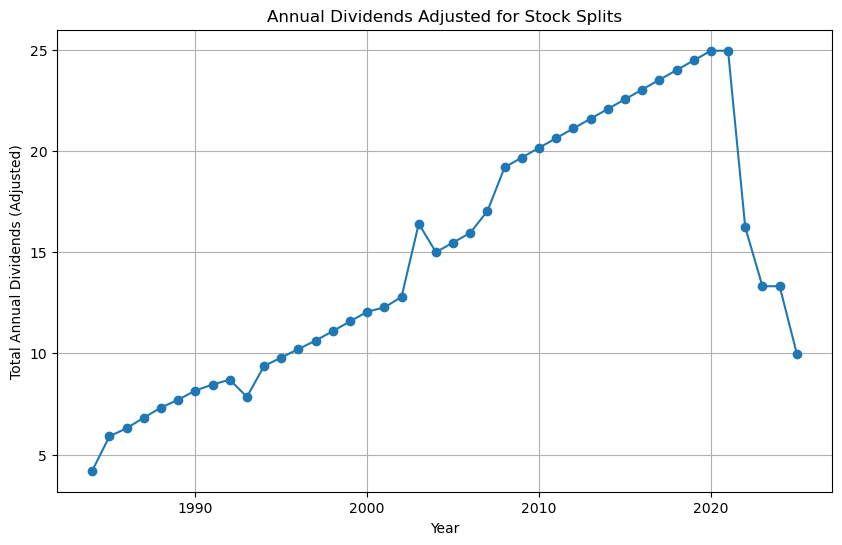

In [9]:
# Plot annual dividends by year
print(f'Plot annual dividends by year from {annual_dividends["Year"].min()} to {annual_dividends["Year"].max()}')
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(annual_dividends['Year'], annual_dividends['Adj Split'], marker='o')
plt.title('Annual Dividends Adjusted for Stock Splits')
plt.xlabel('Year')
plt.ylabel('Total Annual Dividends (Adjusted)')
plt.grid(True)
plt.show()

In [10]:
# Adjusted split change
annual_dividends['Adj Split Change'] = annual_dividends['Adj Split'].pct_change().fillna(0)
annual_dividends


,Year,Adj Split,Adj Split Change
0,1984,4.2000,0.000000
1,1985,5.9000,0.404762
2,1986,6.3000,0.067797
3,1987,6.8200,0.082540
4,1988,7.3200,0.073314
5,1989,7.7100,0.053279
6,1990,8.1600,0.058366
7,1991,8.4600,0.036765
8,1992,8.7000,0.028369
9,1993,7.8525,-0.097414


In [11]:
# Describe the annual dividends data
annual_dividends.describe()

,Year,Adj Split,Adj Split Change
count,42.000000,42.000000,42.000000
mean,2004.500000,14.666607,0.027603
std,12.267844,6.267860,0.115820
min,1984.000000,4.200000,-0.349760
25%,1994.250000,9.480000,0.020102
50%,2004.500000,13.320000,0.026684
75%,2014.750000,20.520000,0.044531
max,2025.000000,24.960000,0.404762


In [12]:
# Calculate the median adjusted split change
dividend_growth_rate = annual_dividends['Adj Split Change'].median()
print(f'Dividend Growth Rate: {dividend_growth_rate:.2%}')
# Assume the dividend will growth nearly median in the future.

Dividend Growth Rate: 2.67%


Calculating cost of equity

In [13]:
# Risk free risk following 10Y Treasury yield
# Fetch US10Y data from yfinance
us10y =  yf.Ticker("^TNX")
us10y_yield = us10y.history(period="1d")['Close'].iloc[-1] / 100  # Convert to decimal
print(f'The latest date of US10Y data: {us10y.history(period="1d").index[-1].date()}')
print(f'10Y Treasury Yield (Risk-Free Rate): {us10y_yield:.2%}')
# Market return S&P 500
sp500 = yf.Ticker("^GSPC")
# Calculate average annual return (CAGR) over the last 5 years as market return (approximation)
# Close + Dividends
sp500_5year = sp500.history(period="5y")
sp500_5year.to_csv('sp500_5year.csv')
# Calculate daily return including dividends
price = sp500_5year['Close'] 
dividend = sp500_5year['Dividends'].fillna(0)
daily_return = (price + dividend)/price.shift(1) - 1
# Calculate geometric mean of daily returns
geom = (1 +daily_return.dropna()).prod()
years = (price.index[-1] - price.index[0]).days / 365.25
sp500_return = geom**(1/years) - 1
print(f'Date range of S&P 500 data: {sp500_5year.index[0].date()} to {sp500_5year.index[-1].date()}')
print(f'S&P 500 Daily Return (5Y CAGR): {daily_return.mean():.2%}')
print(f'S&P 500 Annual Return (5Y CAGR): {sp500_return:.2%}')



The latest date of US10Y data: 2025-09-26
10Y Treasury Yield (Risk-Free Rate): 4.19%
Date range of S&P 500 data: 2020-09-28 to 2025-09-26
S&P 500 Daily Return (5Y CAGR): 0.06%
S&P 500 Annual Return (5Y CAGR): 14.68%


Geometric mean/CAGR = (Ending Value/Beginning Value)^(1/Number of Years) - 1

Annualized Return = (1 + Geometric Mean)^(1/Number of Years) - 1

Use the Capital Asset Pricing Model (CAPM) to calculate the cost of equity for AT&T (Ticker: T).

Cost of Equity = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)
- Risk-Free Rate = 0.0419
- Market Return = 0.1468
- Beta = 0.64


In [14]:
# Beta of AT&T
att = yf.Ticker("T")
att_beta = att.info.get('beta', 1.0)
print(f'Beta of AT&T: {att_beta:.4f}')


Beta of AT&T: 0.6390


In [15]:
# Cost of Equity
risk_free_rate = 0.0419  # 10Y Treasury Yield
market_return = 0.1642  # S&P 500 Annual Return
cost_of_equity = risk_free_rate + att_beta * (market_return - risk_free_rate)
print(f'Cost of Equity: {cost_of_equity:.4f}')
print(f'Cost of Equity in percentage: {cost_of_equity:.2%}')

Cost of Equity: 0.1200
Cost of Equity in percentage: 12.00%


Given:
```
- Beta of AT&T: 0.64
- 10Y Treasury Yield (Risk-Free Rate): 4.19%
- S&P 500 Annual Return (Market Return): 14.68%
```
That means the expected return on equity for AT&T is 12% based on the Capital Asset Pricing Model (CAPM).

Calculating fair value of stock using Dividend Discount Model (DDM)

formula: Fair Value = D1 / (r - g)
- D1 = Dividend next year = D0 * (1 + g)
- r = Cost of Equity
- g = Growth rate of dividends (CAGR of dividends over the last 5 years)

Where:
- D0 = Most recent dividend
- Cost of Equity = 0.12
- Growth rate of dividends (g)

In [16]:
# Calculating fair value of stock using Dividend Discount Model (DDM)
# C = D1 / (r - g)
# Last 4 quarter dividends in dividends table
last_annual_dividend = dividend_table['Amount'].iloc[-4::].sum()
print(f'Last Annual Dividend: ${last_annual_dividend:.4f}')
# Next year dividend assuming the dividend will growth nearly median in the future.
next_year_dividend = last_annual_dividend * (1 + dividend_growth_rate)
print(f'Next Year Dividend: ${next_year_dividend:.4f}')
# Fair Value
fair_value = next_year_dividend / (cost_of_equity - dividend_growth_rate)
print(f'Fair Value of AT&T Stock: ${fair_value:.4f}')
# Current stock price
current_price = att.history(period="1d")['Close'].iloc[-1]
print(f'Current Price of AT&T Stock: ${current_price:.4f}')
# Upside potential
upside_potential = (fair_value - current_price) / current_price
print(f'Upside Potential of AT&T Stock: {upside_potential:.2%}')
# Compare fair value to current price
if fair_value > current_price:
    print("The stock is undervalued.")
else:
    print("The stock is overvalued.")

Last Annual Dividend: $1.1100
Next Year Dividend: $1.1396
Fair Value of AT&T Stock: $12.2060
Current Price of AT&T Stock: $28.3100
Upside Potential of AT&T Stock: -56.88%
The stock is overvalued.


The Dividend Discount Model (DDM) suggests that the fair value of AT&T stock is approximately $12.21, which is significantly lower than its current market price of $28.31. This indicates that the stock may be overvalued by about 56.88%. Investors should consider this information along with other factors before making investment decisions.